# Стажировка в Яндекс.Афише

### <font color=red> Краткий план работ:

    
Шаг 1. Загрузите данные и подготовьте их к анализу
    
Шаг 2. Постройте отчёты и посчитайте метрики

Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?

________________________________________________
    
    

### <span style='color:red;'>Описание данных:</span>
    
_____________________________________________
    
Таблица <span style='color:blue;'>VISITS</span> (лог сервера с информацией о посещениях сайта):

Uid — уникальный идентификатор пользователя

Device — категория устройства пользователя

Start Ts — дата и время начала сессии

End Ts — дата и время окончания сессии

Source Id — идентификатор рекламного источника, из которого пришел пользователь
_______________________________________________

Таблица <span style='color:blue;'>ORDERS</span> (информация о заказах):

Uid — уникальный id пользователя, который сделал заказ

Buy Ts — дата и время заказа

Revenue — выручка Яндекс.Афиши с этого заказа

_____________________________________________
Таблица <span style='color:blue;'>COSTS</span> (информация о затратах на маркетинг):

source_id — идентификатор рекламного источника

dt — дата

costs — затраты на этот рекламный источник в этот день
    

### <span style='color:red;'>Описание проблемы:</span>
    
Необходимо найти пути оптимизации затрат на маркетинг

## Шаг 1. Загрузите данные и подготовьте их к анализу

Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats as st
import datetime

data_visits = pd.read_csv('/datasets/visits_log.csv')
data_orders = pd.read_csv('/datasets/orders_log.csv')
data_costs = pd.read_csv('/datasets/costs.csv')

Проверим корректность данных в таблицах

In [3]:
display(data_visits.info())
display(data_visits.describe())
display(data_visits.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
display(data_orders.info())
display(data_orders.describe())
display(data_orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
display(data_costs.info())
display(data_costs.describe())
display(data_costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Поставим нижнее подчеркивание вместо пробела в названии столбцов

In [6]:
data_visits.columns = data_visits.columns.str.replace("[ ]", "_")
data_orders.columns = data_orders.columns.str.replace("[ ]", "_")
data_costs.columns = data_costs.columns.str.replace("[ ]", "_")

Приведем название столбцов к нижнему регистру

In [7]:
data_visits.columns = data_visits.columns.str.lower()
data_orders.columns = data_orders.columns.str.lower()
data_costs.columns = data_costs.columns.str.lower()

Приведем к единому формату даты

In [8]:
data_visits['end_ts'] = pd.to_datetime(data_visits['end_ts'])
data_visits['start_ts'] = pd.to_datetime(data_visits['start_ts'])
data_costs['dt'] = pd.to_datetime(data_costs['dt'])
data_orders['buy_ts'] = pd.to_datetime(data_orders['buy_ts'])
data_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### Вывод

Подсоединил библиотеки и выгрузили файлы.

Привел таблицы к нужным форматам.

## Шаг 2. Постройте отчёты и посчитайте метрики 

## Продукт

Найдем кол-во людей которые пользуются Я.А. в день, в неделю и в месяц

In [9]:
data_visits['session_year']  = data_visits['start_ts'].dt.year
data_visits['session_month'] = data_visits['start_ts'].dt.month
data_visits['session_week']  = data_visits['start_ts'].dt.week
data_visits['session_date'] = data_visits['start_ts'].dt.date

mau_total = data_visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
dau_total = data_visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = data_visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()

print('Количество людей использующих Я.Афишу в день:', int(dau_total))
print('Количество людей использующих Я.Афишу в неделю:', int(wau_total))
print('Количество людей использующих Я.Афишу в месяц:', int(mau_total))

Количество людей использующих Я.Афишу в день: 907
Количество людей использующих Я.Афишу в неделю: 5716
Количество людей использующих Я.Афишу в месяц: 23228


Добавил дополнительные столбцы для вычислений, использовал их для поиска кол-ва людей за разные периоды.

Из примеров выше мы узнали, сколько в среднем людей пользуются Яндекс Афишей за разный промежуток времени.

Построим график для кол-ва посетителей в день

In [10]:
data_visits['start_ts_day'] = data_visits['start_ts'].astype('datetime64[D]')
visits_graphic_day = data_visits.groupby('start_ts_day')['uid'].nunique().reset_index()
visits_graphic_day.start_ts_day.apply(lambda x: x.date())

0      2017-06-01
1      2017-06-02
2      2017-06-03
3      2017-06-04
4      2017-06-05
          ...    
359    2018-05-27
360    2018-05-28
361    2018-05-29
362    2018-05-30
363    2018-05-31
Name: start_ts_day, Length: 364, dtype: object

Text(0, 0.5, 'Кол-во посетителей в день')

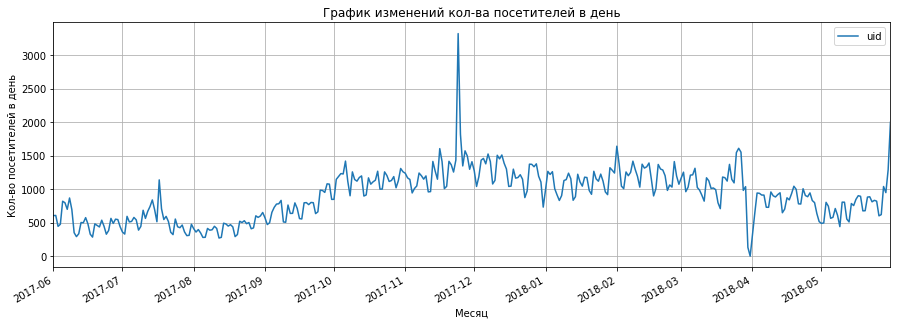

In [11]:
visits_graphic_day.pivot_table(index='start_ts_day', values='uid',  aggfunc='sum').plot(figsize=(15, 5), grid=True)
plt.title('График изменений кол-ва посетителей в день')
plt.xlabel('Месяц')
plt.ylabel('Кол-во посетителей в день')

На графике можно выделить пик, который приходится ближе к началу декабря.

Можно предположить, что наибольшее кол-во посещений/покупок происходят именно в зимний период, в то время как летний и весенний сильно проседают по этому показателю

Вопрос: Как построить более  читабельный график? все дни соеденились в черное пятно

upd. Готово

Построим график для кол-ва посетителей в неделю

Text(0, 0.5, 'Кол-во посетителей в неделю')

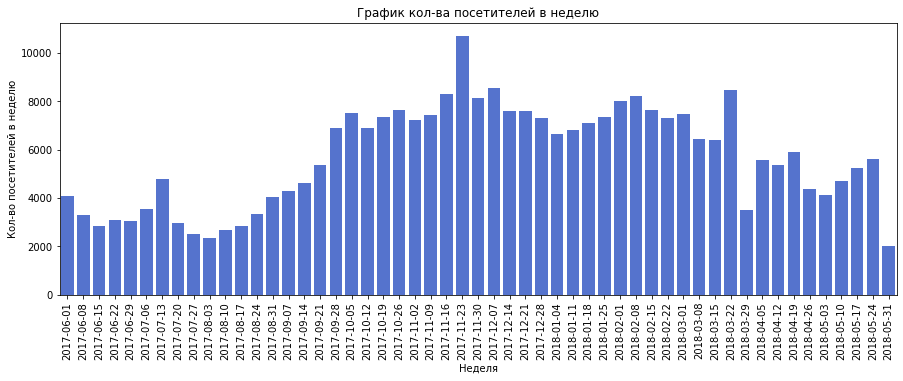

In [12]:
data_visits['start_ts_weekday'] = data_visits['start_ts'].astype('datetime64[W]')
visits_graphic_weekday = data_visits.groupby('start_ts_weekday')['uid'].nunique().reset_index()
visits_graphic_weekday.start_ts_weekday.apply(lambda x: x.date())
plt.figure(figsize=(15, 5))
b = sns.barplot(data=visits_graphic_weekday, x='start_ts_weekday', y='uid', color='RoyalBlue')
b.set_xticklabels(visits_graphic_weekday.start_ts_weekday.apply(lambda x: x.date()), rotation=90)
b.set_title('График кол-ва посетителей в неделю')
b.set_xlabel('Неделя')
b.set_ylabel('Кол-во посетителей в неделю')

К началу осени пользователи начинают активизироваться вплоть до начала весны, это можно связать с холодным климатом в России, и что пользователи больше времени проводят дома ища досуг.

Построим график для кол-ва посетителей в месяц

Text(0, 0.5, 'Кол-во посетителей в месяц')

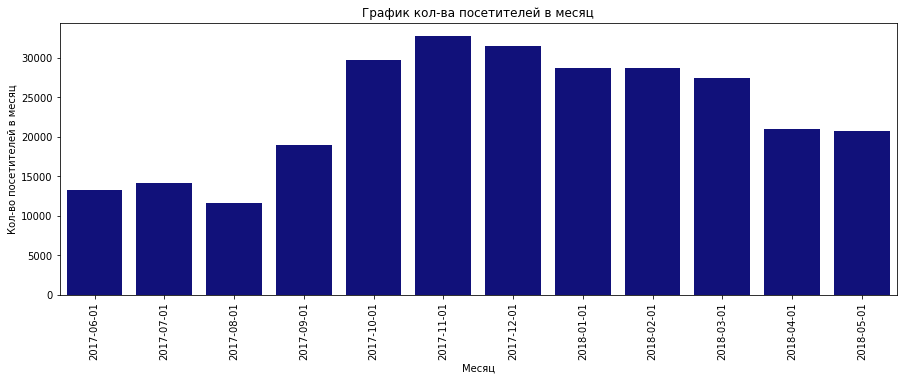

In [13]:
data_visits['start_ts_month'] = data_visits['start_ts'].astype('datetime64[M]')
visits_graphic_month = data_visits.groupby('start_ts_month')['uid'].nunique().reset_index()
visits_graphic_month.start_ts_month.apply(lambda x: x.date())
plt.figure(figsize=(15, 5))
c = sns.barplot(data=visits_graphic_month, x='start_ts_month', y='uid', color='DarkBlue')
c.set_xticklabels(visits_graphic_month.start_ts_month.apply(lambda x: x.date()), rotation=90)
c.set_title('График кол-ва посетителей в месяц')
c.set_xlabel('Месяц')
c.set_ylabel('Кол-во посетителей в месяц')

Как я описал в графике недель, здесь мы можем укрепить нашу теорию о том, что осень и зима являются пиковыеми временами года, когда пользователи проявляют наибольшую активность.

Найдем кол-во сессий в день на одного посетителя

In [14]:
sessions_per_user = data_visits.groupby(['session_date', 'device']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user = sessions_per_user.reset_index()
sessions_per_user.groupby(['device']).agg({'sess_per_user' : 'mean'})
sessions_per_user['session_date'] = sessions_per_user['session_date'].astype('datetime64[D]')
sessions_per_user

,session_date,device,n_sessions,n_users,sess_per_user
0,2017-06-01,desktop,501,455,1.101099
1,2017-06-01,touch,163,153,1.065359
2,2017-06-02,desktop,498,458,1.087336
3,2017-06-02,touch,160,152,1.052632
4,2017-06-03,desktop,329,307,1.071661
...,...,...,...,...,...
722,2018-05-29,touch,284,263,1.079848
723,2018-05-30,desktop,989,904,1.094027
724,2018-05-30,touch,421,393,1.071247
725,2018-05-31,desktop,1544,1361,1.134460


В среднем пользователей совершает одну сессию в день, что вполне нормально для подобного ресурса.


upd. Разница между пользователем компьютера и мобильного телефона очень незначительна.

Построим график для среднего кол-ва сессий в день на одного пользователя

Text(0, 0.5, 'Кол-во сессий в день')

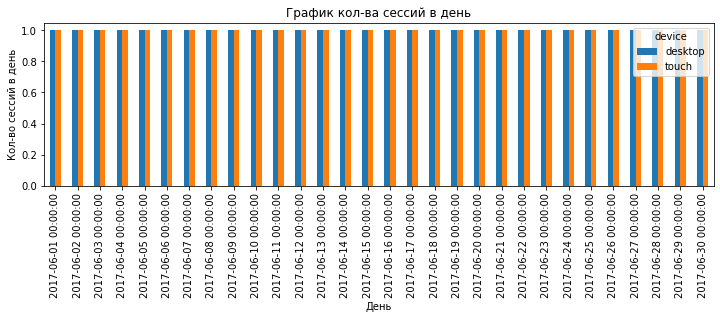

In [15]:
sessions_per_user['session_date_day'] = sessions_per_user['session_date'].astype('datetime64[D]')
sessions_per_user = sessions_per_user.loc[sessions_per_user['session_date_day'] < '2017-07-01' ]
sessions_per_user.pivot_table(index='session_date_day', values='sess_per_user', columns='device',  aggfunc='count').plot(figsize=(12, 3), kind='bar', grid=False)
plt.title('График кол-ва сессий в день')
plt.xlabel('День')
plt.ylabel('Кол-во сессий в день')

Вопрос аналогичным выше, как лучше использовать график и подписи? возможно лучше разбить по неделям или месяцам? и нужен ли он тут в целом?

upd. готово

upd2. Заменил на гистограмму и выставил ограничение в один месяц для удобства просмотра

Найдем среднюю продолжительность сессии

In [16]:
data_visits['session_duration_sec'] = (data_visits['end_ts'] - data_visits['start_ts']).dt.seconds
data_visits['session_duration_sec'].mean()

643.506488592098

Проверим на равномерность распределений


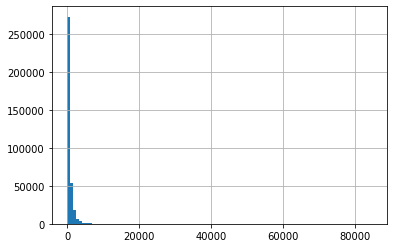

In [17]:
data_visits['session_duration_sec'].hist(bins=100)

Тк распределение неравномерное, найдем моду, значение которое встречается чаще остальных


In [18]:
data_visits['session_duration_sec'].mode()

0    60
dtype: int64

60 секунд в среднем длится сессия пользователя.

Для продукта Яндекс Афиша, где можно посмотреть грядущие мероприятия и купить на них билеты это маленькое время.

В идеале процесс выстроен следущими шагами: Пользователь заходит на сайт/в приложение -> выбирает нужную дату -> выбирает мероприятие -> оплачивает билеты.

И это должно занимать не меньше 300 секунд

Как часто люди возвращаются?

In [19]:
data_visits['session_date'] = pd.to_datetime(data_visits['session_date'])
data_visits['month'] = data_visits['session_date'].astype('datetime64[M]')
first_visits_date = data_visits.groupby(['uid'])['session_date'].min()
first_visits_date.name = 'first_visits_date'
data_visits1 = data_visits.join(first_visits_date,on='uid')
data_visits1['visits_month'] = data_visits['session_date'].astype('datetime64[M]')
data_visits1['first_visits_month'] = data_visits1['first_visits_date'].astype('datetime64[M]')
data_visits1['cohort_lifetime'] = data_visits1['visits_month'] - data_visits1['first_visits_month']
data_visits1['cohort_lifetime'] = data_visits1['cohort_lifetime'] / np.timedelta64(1,'M')
data_visits1['cohort_lifetime'] = data_visits1['cohort_lifetime'].astype('int')
cohorts = data_visits1.groupby(['first_visits_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visits_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_visits_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_visits_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot.index = retention_pivot.index.strftime("%m/%Y")
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10
06/2017,1.0,NaN,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.084018,0.040652,0.044951
07/2017,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.073744,NaN,0.049239,NaN
08/2017,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.065809,0.027895,0.026029,NaN,NaN
09/2017,1.0,NaN,0.102490,NaN,0.039392,0.065673,0.024186,0.022809,NaN,NaN,NaN
10/2017,1.0,0.078608,0.052239,0.038958,0.058860,0.021365,0.020364,NaN,NaN,NaN,NaN
11/2017,1.0,NaN,0.044113,0.065069,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
12/2017,1.0,0.055802,0.062134,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
01/2018,1.0,0.089816,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2018,1.0,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/2018,1.0,0.041818,0.027053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту

Text(93.5, 0.5, 'Месяц')

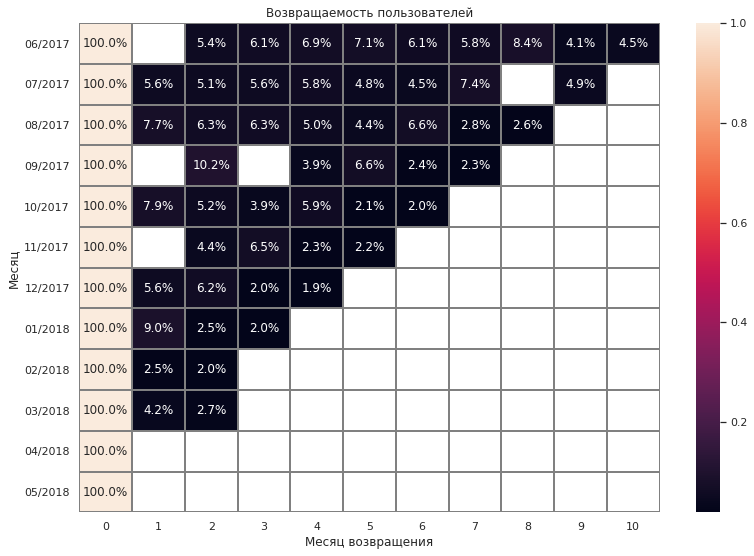

In [20]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');
plt.title('Возвращаемость пользователей')
plt.xlabel('Месяц возвращения')
plt.ylabel('Месяц')

### Вывод

Мы провели небольшое исследование продукта и вот что удалось выяснить:

1. Пиковое кол-во посетителей, не важно в день, в месяц или в неделю приходится на осенне-зимний период.

2. Пользователи мобильных телефонов и пользователи компьютеров совершают почти одинаковое кол-во сессий в день.

3. Средняя продолжительность сессии - 60 секунду, что достаточно мало для нашего ресурса.

4. Возвращаемость в первый месяц использования Я.А. составляет 100%

## Продажи

Когда люди начинают покупать?
Создадим таблицу которая покажет когда была сделана первая покупка методом группировки

In [21]:
first_orders_dates = data_orders.groupby('uid')['buy_ts'].min()
first_orders_dates.name = 'first_orders_datetime'

объединим таблицы

найдем номера сессий когда пользователи проявляют активность

In [22]:
data_orders = data_orders.merge(first_orders_dates, on='uid')
data_visits['num_of_session'] = data_visits.sort_values(['uid','start_ts'], ascending=[True,True]) \
             .groupby(['uid']) \
             .cumcount() + 1
data_visits.sort_values(by = ['uid', 'num_of_session'])

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,start_ts_day,start_ts_weekday,start_ts_month,session_duration_sec,month,num_of_session
196543,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,11863502262781,2018,3,9,2018-03-01,2018-03-01,2018-03-01,2018-03-01,360,2018-03-01,1
257333,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,49537067089222,2018,2,6,2018-02-06,2018-02-06,2018-02-01,2018-02-01,120,2018-02-01,1
173818,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,297729379853735,2017,6,23,2017-06-07,2017-06-07,2017-06-01,2017-06-01,60,2017-06-01,1
173142,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,313578113262317,2017,9,38,2017-09-18,2017-09-18,2017-09-14,2017-09-01,1080,2017-09-01,1
192554,desktop,2018-02-18 15:26:00,2,2018-02-18 15:17:00,313578113262317,2018,2,7,2018-02-18,2018-02-18,2018-02-15,2018-02-01,540,2018-02-01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175259,touch,2017-12-06 20:32:00,4,2017-12-06 20:32:00,18446424184725333426,2017,12,49,2017-12-06,2017-12-06,2017-11-30,2017-12-01,0,2017-12-01,1
293449,touch,2018-01-01 16:31:00,3,2018-01-01 16:29:00,18446556406699109058,2018,1,1,2018-01-01,2018-01-01,2017-12-28,2018-01-01,120,2018-01-01,1
319162,desktop,2017-12-27 14:08:00,4,2017-12-27 13:27:00,18446621818809592527,2017,12,52,2017-12-27,2017-12-27,2017-12-21,2017-12-01,2460,2017-12-01,1
222173,desktop,2018-05-21 09:45:00,4,2018-05-21 09:30:00,18446621818809592527,2018,5,21,2018-05-21,2018-05-21,2018-05-17,2018-05-01,900,2018-05-01,2


Объединим таблицы 

In [23]:
data_orders_session = data_visits.merge(data_orders, on='uid')
data_orders_session1 = data_orders_session.groupby('first_orders_datetime')['num_of_session'].sum().reset_index()
print(data_orders_session1['num_of_session'].value_counts())

1          15514
3           6259
6           3741
2           1089
10          1063
           ...  
5328           1
4318510        1
115            1
243            1
8596           1
Name: num_of_session, Length: 499, dtype: int64


Из таблицы выше мы можем сделать вывод, что асболютное большинство пользователей совершают покупку в свою первую сессию.

То есть большинство пользователей изначально знает зачем переходит на сайт, что он там найдет и что ему самому требуется.

Сколько раз покупают за период?

Text(93.5, 0.5, 'Первый месяц заказа')

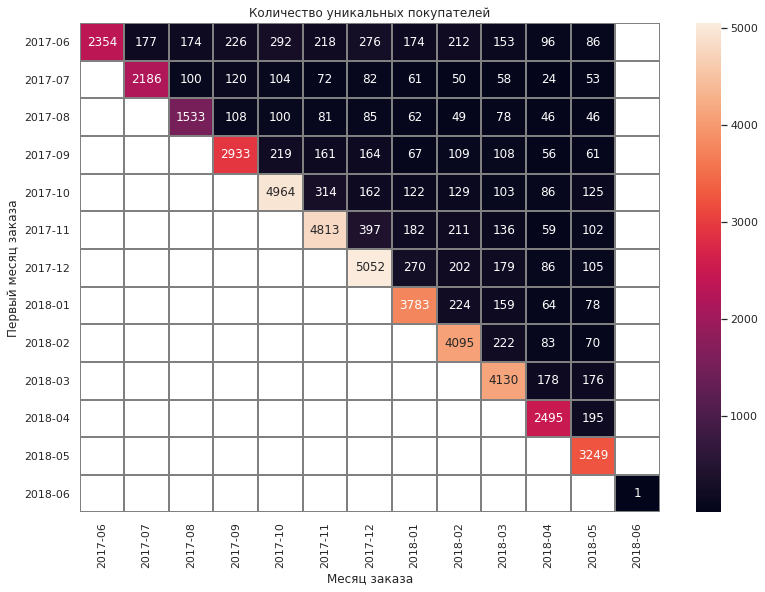

In [24]:
first_order_date = data_orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
orders_log = data_orders.join(first_order_date,on='uid')
orders_log_new = orders_log
orders_log_new['first_order_month'] =  orders_log_new['first_order_date'].astype('datetime64[M]')
orders_log_new['order_month'] = orders_log_new['buy_ts'].astype('datetime64[M]')
orders_log_new['first_order_month'] = orders_log_new['first_order_month'].dt.strftime('%Y-%m')
orders_log_new['order_month'] = orders_log_new['order_month'].dt.strftime('%Y-%m')
orders_log_pivot = orders_log_new.pivot_table(index='first_order_month',
                                columns='order_month',
                                values='uid',
                                aggfunc='count')
 
plt.figure(figsize=(13, 9))
sns.heatmap(orders_log_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray')
plt.title('Количество уникальных покупателей')
plt.xlabel('Месяц заказа')
plt.ylabel('Первый месяц заказа')

Как и ожидалось, в среднем за месяц покупают один раз, что нормально для нашего сервиса

Найдем средний чек

In [25]:
data_orders['month'] = data_orders['buy_ts'].astype('datetime64[M]')
first_order_date_by_customers = data_orders.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
data_orders = data_orders.join(first_order_date_by_customers,on='uid')
data_orders['first_order_month1'] = data_orders['first_order_date'].astype('datetime64[M]')
data_orders['order_month'] = data_orders['buy_ts'].astype('datetime64[M]')

In [26]:
orders_grouped_by_cohorts = data_orders.groupby(['first_order_month1','order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts.pivot_table(index='first_order_month1',columns='order_month',values='revenue_per_user',aggfunc='mean')
orders_grouped_by_cohorts['revenue_per_user'].mean()

14.733567597262237

Text(0, 0.5, 'Средний чек')

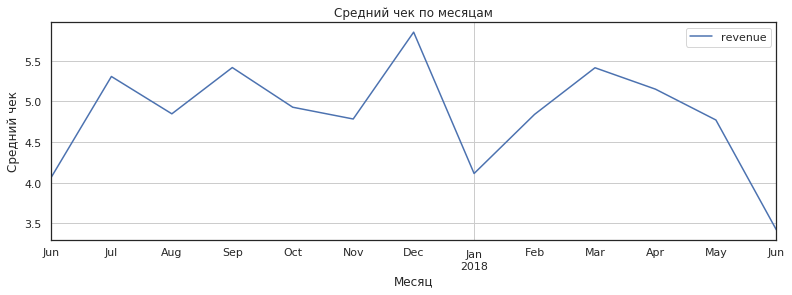

In [27]:
data_orders.pivot_table(index='order_month', values='revenue',  aggfunc='mean').plot(figsize=(13, 4), grid=True)
plt.title('Средний чек по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')

Исходя из график могу предположить, что в январе самый низкий средний чек потому что там много выходных дней, люди после новогодних праздников, и так потратили большую часть свои финансов.

В целом, весь год относительно ровен кроме данного месяца, возможно у нас нехватает каких либо данных.

Cколько денег приносят? LTV
Cоздадим когорты

In [28]:
data_costs['cost_month'] = data_costs['dt'].astype('datetime64[M]')
first_orders = data_orders.groupby('uid').agg({'month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

Посчитаем кол-во новых покупателей

In [29]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Построим когорты и сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку

In [30]:
orders_new = pd.merge(data_orders,first_orders, on='uid')
cohorts = orders_new.groupby(['first_order_month','month']).agg({'revenue': 'sum'}).reset_index()

Добавим данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [31]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

Найтем валовую прибыль, умножив выручку на маржинальность

In [32]:
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate

LTV — относительный показатель, соответственно его удобнее смотреть по «возрастным» когортам

In [33]:
report['age'] = (report['month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')#.round()
    
output.fillna('')
output.cumsum(axis=1).mean(axis=0)

age
0      4.801682
1      5.395666
2      5.821811
3      6.689763
4      7.298634
5      7.969053
6      8.387686
7      9.083583
8     10.062084
9      9.251340
10    10.004616
11    11.879234
dtype: float64

Усреднив когорты мы узнали, что самая высокая ценность покупателей появляется на 9, 11 и 12 месяц.

Возьмем период в 6 месяцев

In [34]:
six_month_cohort_ltv = output[[0,1,2,3,4,5]].head(10)
six_month_cohort_ltv

age,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN
2018-02-01,4.156987,0.278274,0.078515,0.074144,NaN,NaN


Построим тепловую карту

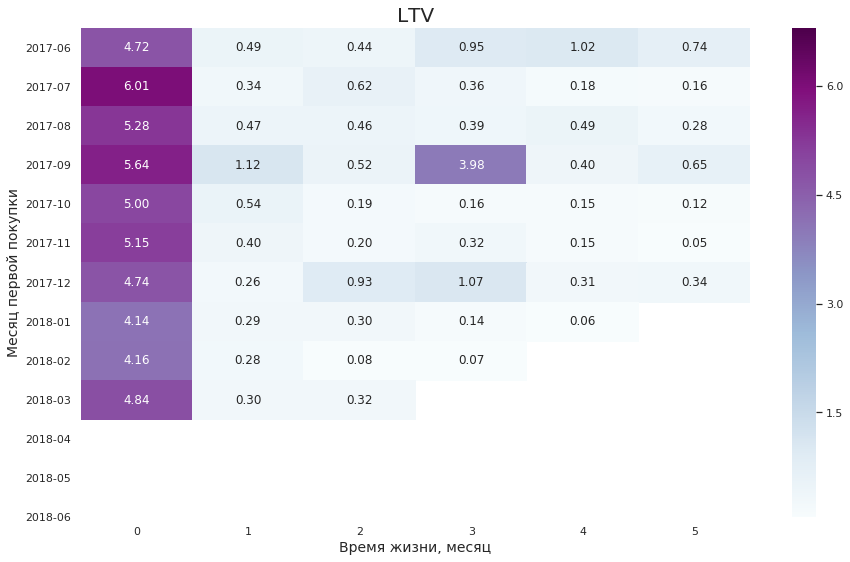

In [35]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV', fontsize=20)
sns.heatmap(six_month_cohort_ltv, cmap="BuPu", annot=True, fmt='.2f', vmax= 6.8, linecolor='gray', yticklabels=output.index.strftime('%Y-%m'),)
plt.xlabel('Время жизни, месяц', fontsize=14)
plt.ylabel('Месяц первой покупки', fontsize=14) 
plt.show()

Как видно из графика, наибольшую ценность покупатель из себя представляет именно в первый месяц использования Я.А, в этот период и определяется его "пожизненная ценность".

Так же мы можем отметить аномалию, которая появилась на 4 месяце в сентябре 2017, когда была очень высокая ценность покупателей

### Вывод

Подведем итоги, что нам удалось узнать о продажах:

1. Большая часть пользователей совершает свою первую покупку в первую же сессию, что говорит о том, что аудитория знает зачем идет на Я.А.

2. В среднем за период один пользователь совершает одну покупку, всё таки Я.А. больше развлекательного характера, нежели полноценный e-com проект.

3. Средний чек зависит от периода, в зимнее время года он выше, в летнее ниже, но остается примерно на уровне 4,5 y.e.

4. Наибольшую "пожизненную" ценность пользователь представляет в месяц пользования Я.А., в среднем принося 3 y.e.

## Маркетинг

Посчитаем сколько денег потратили всего

In [36]:
total_costs = data_costs.pivot_table(index='source_id', values='costs', aggfunc='sum')
total_costs.sum()

costs    329131.62
dtype: float64

На всю рекламную кампанию было потрачено 329 131 y.e.

Cколько потратили на каждый источник

In [1]:
total_costs_source = data_costs.pivot_table(index='source_id', values='costs', aggfunc='sum')
total_costs_source.info()

Построим график для наглядности

Text(0, 0.5, 'Расходы, y.e.')

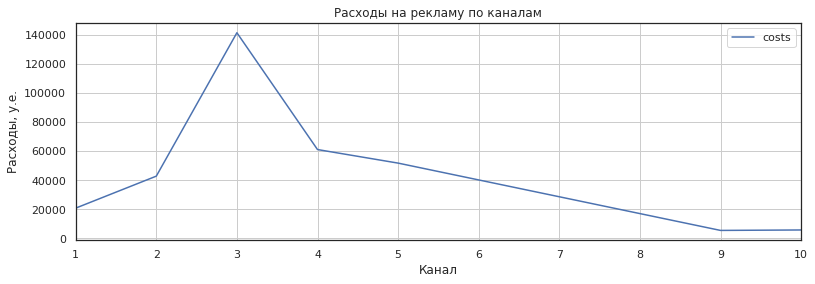

In [63]:
total_costs_source.pivot_table(index='source_id', values='costs',  aggfunc='sum').plot(figsize=(13, 4), grid=True)
plt.title('Расходы на рекламу по каналам')
plt.xlabel('Канал')
plt.ylabel('Расходы, y.e.')

Наибольшие расходы пришлись на источник № 3, вдвое больше чем у ближайшего конкурента № 4.

Найдем расходы на каждый месяц

In [64]:
data_costs['month'] = data_costs['dt'].astype('datetime64[M]')
total_costs_time = data_costs.pivot_table(index='month', values='costs', aggfunc='sum')
total_costs_time

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


Построим график расходов по месяцам

Text(0, 0.5, 'Расходы, y.e.')

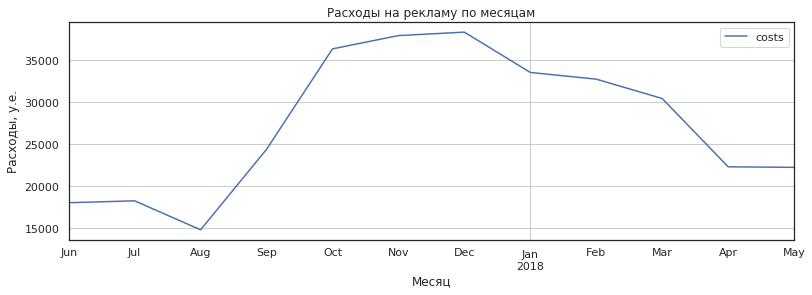

In [65]:
total_costs_time.pivot_table(index='month', values='costs',  aggfunc='sum').plot(figsize=(13, 4), grid=True)
plt.title('Расходы на рекламу по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы, y.e.')

Наибольшие расходы пришлись на зимний период, тогда как летом эти расходы были минимальны.

Если сопоставить с графиком по среднему чеку, то увидим закономерность: самый большой средний чек - декабрь, самые большие затраты на рекламу - декабрь.

Сколько стоило привлечение одного покупателя из каждого источника

Сгруппируем таблицы

In [102]:
monthly_costs = data_costs.groupby('month').sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')

Найдем САС

In [103]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new

,first_order_month,n_buyers,month,revenue,gp,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,1020,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,1020,18015.00,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,1020,18015.00,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,1020,18015.00,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,1020,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892,1025,30415.27,8.608907
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559,1025,30415.27,8.608907
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597,986,22289.38,9.793225
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599,986,22289.38,9.793225


Визуализируем данные

Text(0, 0.5, 'Y.E. для привлечения')

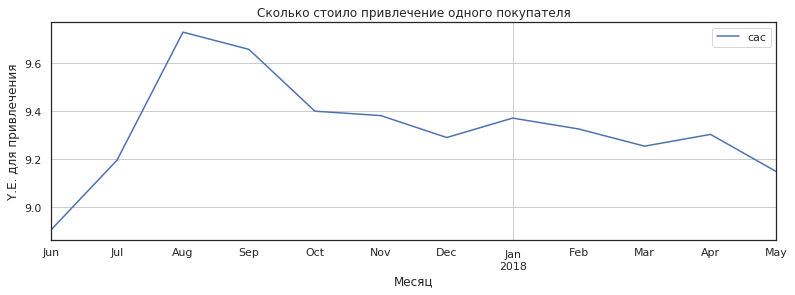

In [104]:
report_new.pivot_table(index='month', values='cac',  aggfunc='mean').plot(figsize=(13, 4), grid=True)
plt.title('Сколько стоило привлечение одного покупателя')
plt.xlabel('Месяц')
plt.ylabel('Y.E. для привлечения')

Посчитаем окупаемость (ROI)

In [117]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
result = report_new.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

#result.fillna('')
result.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

Выше мы нашли среднюю когорту и узнали что она начинает окупаться на 9 месяцев

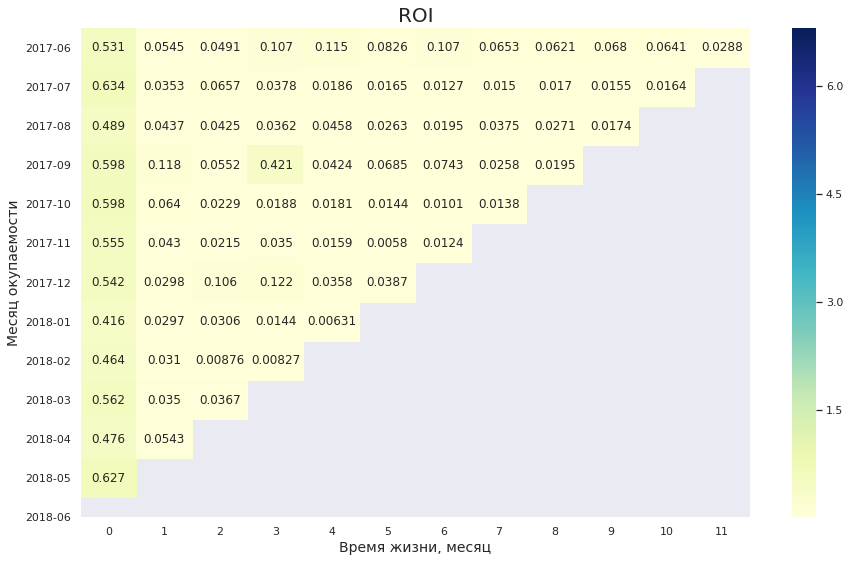

In [118]:
sns.set(style='dark')
plt.figure(figsize=(15, 9))
plt.title('ROI', fontsize=20)
sns.heatmap(result, cmap="YlGnBu", annot=True, fmt='.3', vmax= 6.8, linecolor='gray', yticklabels=output.index.strftime('%Y-%m'),)
plt.xlabel('Время жизни, месяц', fontsize=14)
plt.ylabel('Месяц окупаемости', fontsize=14) 
plt.show()

По данному графику можно сделать вывод, что ни одна когорта не окупается за период жизни.

Показатель окупаемости не переваливается за единицу даже спустя год.

### Вывод

1. За все время на маркетинговую кампанию было потрачено - 329 131. Из них большая часть пришла на источник трафика № 3, а самые большие затраты были произведены в осенне-зимний период

2. Далее последовало интересное наблюдение, что при низких затратах на рекламу весной и летом, именно в этот период затраты на привлечение одно клиента самые высокие.

3. При вычислении накопительного ROI по всем когортам мы выяснили, что на окупаемость Я.А. выходит только на 9 месяц, что достаточно долго. Если брать среднее по всем когортам, то об окупаемости речи в принципе не идет.

## Общий вывод

Мы провели исследование ресурса Яндекс Афиша, вспомним то, что нам уже известно:

1. Построив 3 графика по посещениям (день, неделя, месяц), мы увидели, что осенне-зимний период является наиболее популярным у пользователей, тогда как весной и летом кол-во пользователей меньше на треть.

2. В среднем, один пользователь совершает одну сессию в день, независимо от устройства.

3. Средняя продолжительность сессии у пользователя - 60 секунд.

4. Самая высокая возвращаемость происходит в первый месяц использования.

5. Большая часть пользователей совершает свою первую покупку в первую же сессию, что говорит о том, что аудитория знает зачем идет на Я.А.

6. В среднем за период один пользователь совершает одну покупку, всё таки Я.А. больше развлекательного характера, нежели полноценный e-com проект.

7. Средний чек зависит от периода, в зимнее время года он выше, в летнее ниже, но остается примерно на уровне 4,5 y.e.

8. Наибольшую "пожизненную" ценность пользователь представляет в месяц пользования Я.А., в среднем принося 3 y.e.

9. За все время на маркетинговую кампанию было потрачено - 329 131. Из них большая часть пришла на источник трафика № 3, а самые большие затраты были произведены в осенне-зимний период

10. Далее последовало интересное наблюдение, что при низких затратах на рекламу весной и летом, именно в этот период затраты на привлечение одно клиента самые высокие.

11. При вычислении накопительного ROI по всем когортам мы выяснили, что на окупаемость Я.А. выходит только на 9 месяц, что достаточно долго. Если брать среднее по всем когортам, то об окупаемости речи в принципе не идет.

